Link de la presentación: 
https://www.canva.com/design/DAFeCjArLw4/3XnYvJBzbpoGrMTpJg-FMw/view?utm_content=DAFeCjArLw4&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

In [1]:
# Importar librerías:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import geopandas as gpd
from apyori import apriori
from collections import Counter
from wordcloud import WordCloud 
from dateutil.parser import parse 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 120})
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Cargar dataset
data = pd.read_csv('ds_onlineRetail.csv', encoding='ISO-8859-1')
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Eliminar filas sin países
data = data.loc[(data['Country'] != "Unspecified")] 
# Calculo las ventas totatles
data['VentasTotales'] = data.Quantity * data.UnitPrice
data.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerI

In [4]:
data.describe()

,Quantity,UnitPrice,CustomerID,VentasTotales
count,541463.000000,541463.000000,406585.000000,541463.000000
mean,9.554023,4.612688,15288.630473,17.993839
std,218.170802,96.799645,1713.284209,378.966647
min,-80995.000000,-11062.060000,12346.000000,-168469.600000
25%,1.000000,1.250000,13956.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [5]:
#data.UnitPrice.sort_values
len(data[data["UnitPrice"]<0])

2

## Gráficos

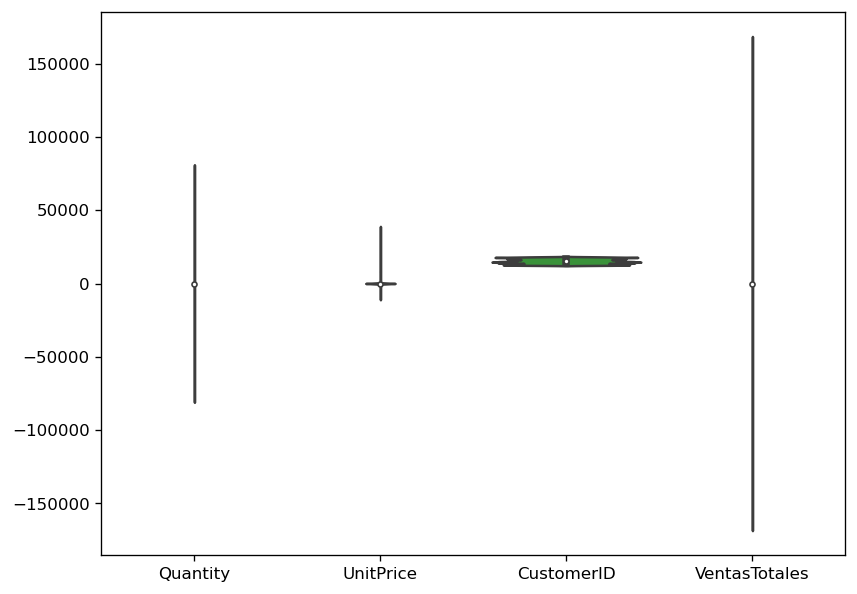

In [6]:
# Distribución de las variables
sns.violinplot(data=data)
#plt.title("Escala de los datos")
plt.show()

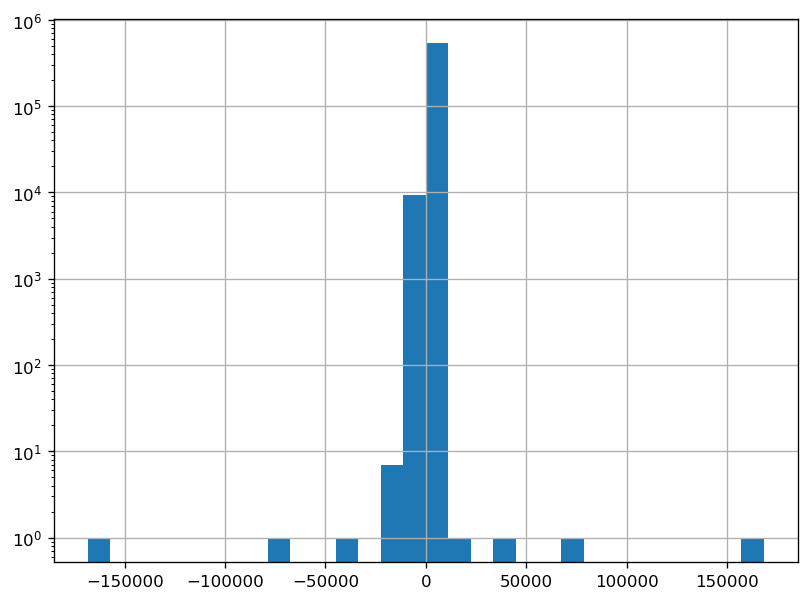

In [7]:
# Historama de Vental Total (30 días = 1 mes), hay muchas ventas están ubicadas entre 0 y 100 000
data.VentasTotales.hist(bins=30)
#plt.title("Ventas Totales")
plt.yscale('log')
# Casi todas compras de cosas cerca a cero

In [8]:
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha de minutos/segundos 
data['Date'] = data['InvoiceDate'].dt.date
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,VentasTotales,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


<function matplotlib.pyplot.show(close=None, block=None)>

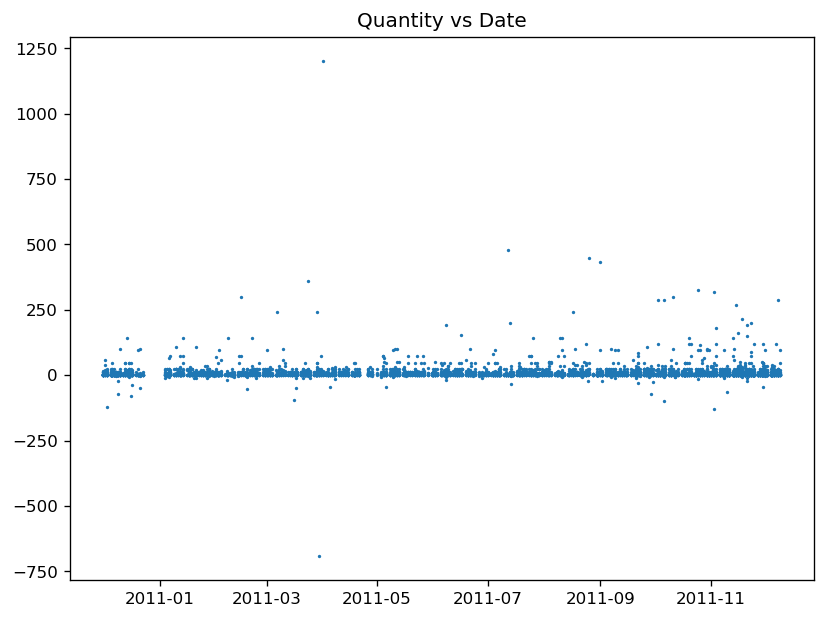

In [9]:
# Distribución a lo largo del tiempo (el proceso de venta está estable en el tiempo)
dataShort = data[::100]
plt.scatter(dataShort["Date"], dataShort["Quantity"] , s=1)
plt.title("Quantity vs Date")
plt.show
# Conforme pasa el tiempo no se vende más ni menos

Text(0.5, 1.0, 'Variación del CustomerID')

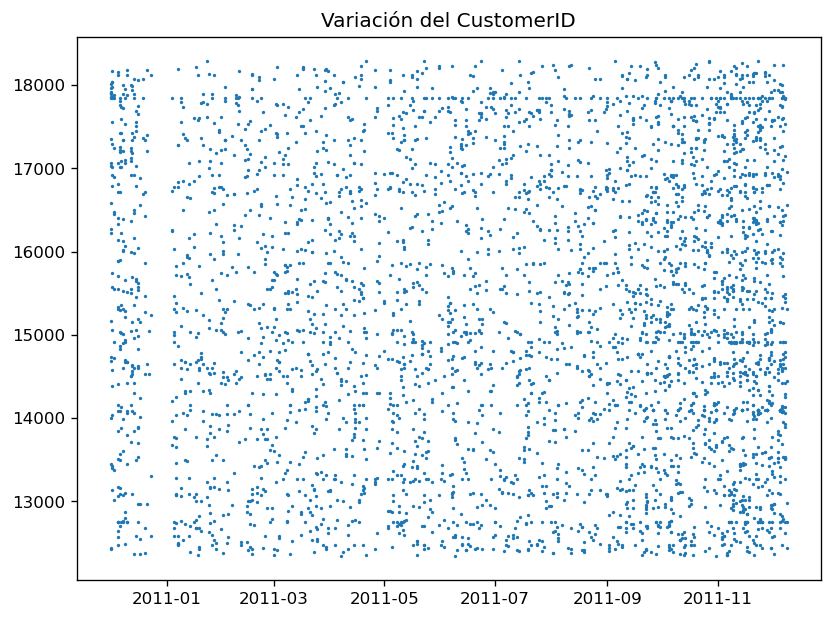

In [10]:
plt.scatter(dataShort["Date"], dataShort["CustomerID"], s=1)
plt.title("Variación del CustomerID")
# No hay variación en el rago del tiempo, es una continuación, no hay tendencia ( es constante) No hay aumento de la catn de ctes. 

Text(0.5, 1.0, 'Mapa de Correlación')

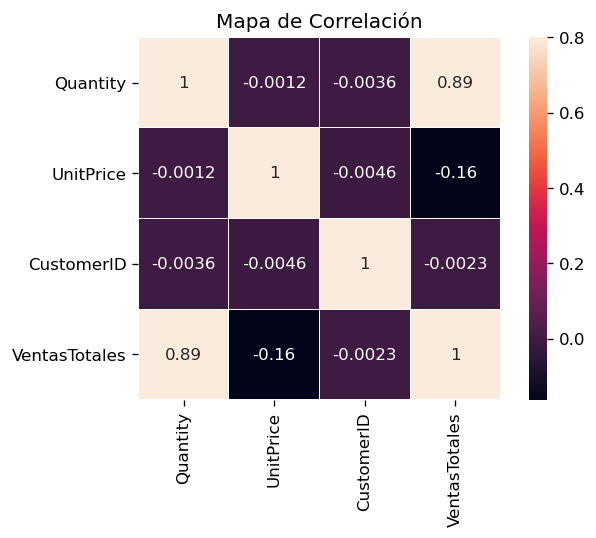

In [11]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)
plt.title("Mapa de Correlación")
# Hay una relación fuerte entre la venta total y quantily 

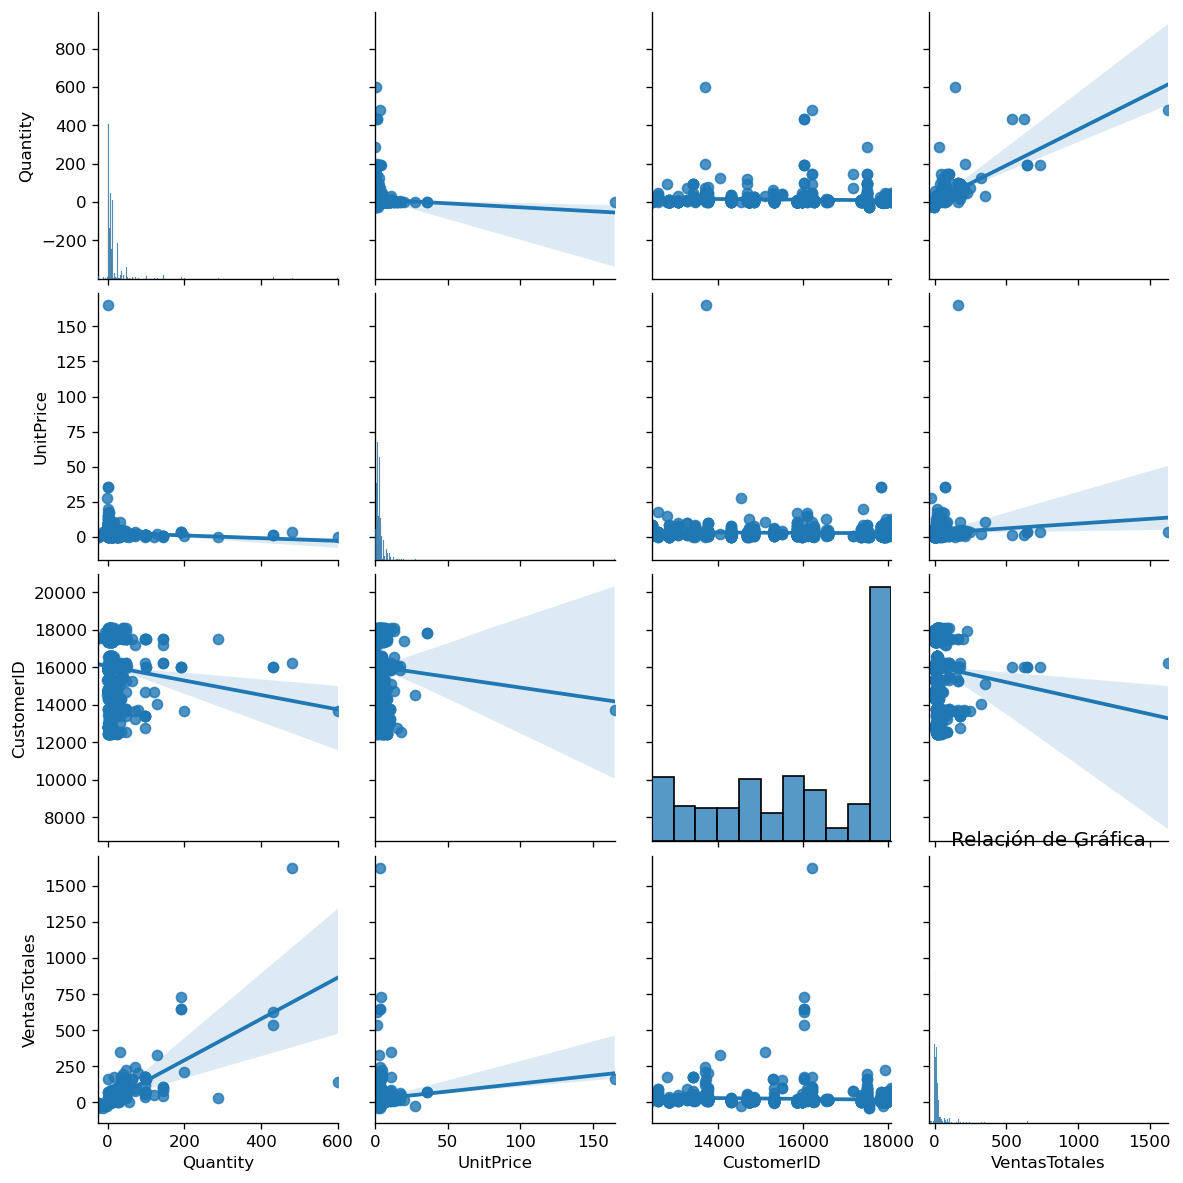

In [12]:
# Seaborn o PairGrid:
sns.pairplot(data[:1000], kind="reg")
plt.title("Relación de Gráfica")
plt.show()
# Más detalle de la correlación. 
# En la 1° gráfico muestra la relación de la cantidad de las compras.
# La gráfica muestra que lso clientes son los más recientes.

In [13]:
paises = ['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Brazil', 'United States of America',
       'European Community', 'Malta', 'RSA']
df = pd.DataFrame(paises,columns=['paises x filtrar'])


Channel Islands united king
Bahrain emiratos 
Hong Kong china
Singapore malasia
Czech Republic Czech of Republic 
European Community - 
Malta - 

In [14]:
#len(data['Country'].unique())
#buscar_data = paises_geo_pandas['name'].str.contains('Fra') == True
#paises_geo_pandas['name'].unique()
#paises_geo_pandas[paises_geo_pandas['name'] == 'Czech of Republic']
df['paises x filtrar'].str.contains("|".join(paises_geo_pandas['name']))
df_nuevo = df[df['paises x filtrar'].str.contains("|".join(paises_geo_pandas['name']))==False]
df_nuevo.head(2)

NameError: name 'paises_geo_pandas' is not defined

In [ ]:
#paises_geo_pandas.name.sort_values
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Czechia"]
data['Country'] = data['Country'].apply(lambda x : x.replace("EIRE", "Ireland"))
data['Country'] = data['Country'].apply(lambda x : x.replace("RSA", "Russia"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Hong Kong", "China"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Singapore", "Malaysia"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Czech Republic", "Czechia"))
data['Country'] = data['Country'].apply(lambda x : x.replace("USA", "United States of America"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Channel Islands", "United Kingdom"))
data['Country'].unique()

In [ ]:
vtas_totales_paises = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
vtas_totales_paises = vtas_totales_paises.sort_values('venta_total',ascending=False)
vtas_totales_paises["logVentaTotal"] = np.log10(vtas_totales_paises["venta_total"])
vtas_totales_paises.head(2)

In [ ]:
# Reducir para mostrar los 20 primeros
vtas_totales_paises_ = vtas_totales_paises[:20]
# Crear la gráfica de barras
plt.bar(vtas_totales_paises_.Country, vtas_totales_paises_['venta_total'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Top Ventas en 20 Países")
plt.show()

In [ ]:
# Gráfica de dispersión (scatter) de Quantity vs UnitPrice 
plt.scatter(vtas_totales_paises['Quantity'], vtas_totales_paises['UnitPrice'], s=4)
plt.title("Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.xscale('log')
plt.yscale('log')
plt.show()
# Cuándo se compran grandes cantidad es de precio alto.

In [17]:
data.Description

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905           CHILDREN'S APRON DOLLY GIRL 
541906          CHILDRENS CUTLERY DOLLY GIRL 
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908          BAKING SET 9 PIECE RETROSPOT 
Name: Description, Length: 541463, dtype: object

In [15]:
titles=''.join(str(data.Description)).lower()
titles

"0          white hanging heart t-light holder\n1                         white metal lantern\n2              cream cupid hearts coat hanger\n3         knitted union flag hot water bottle\n4              red woolly hottie white heart.\n                         ...                 \n541904            pack of 20 spaceboy napkins\n541905           children's apron dolly girl \n541906          childrens cutlery dolly girl \n541907        childrens cutlery circus parade\n541908          baking set 9 piece retrospot \nname: description, length: 541463, dtype: object"

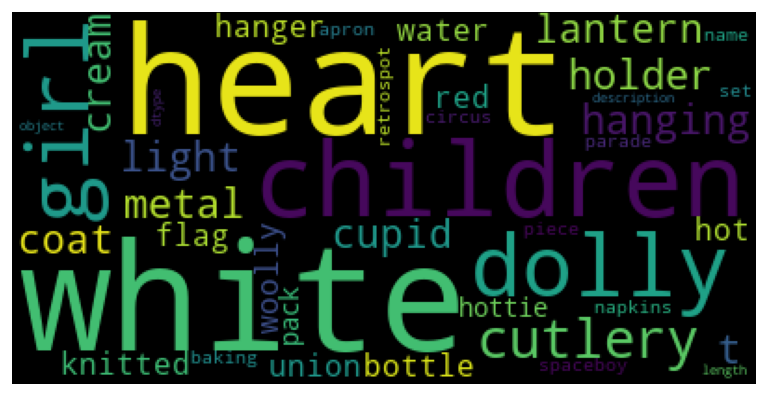

In [16]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [ ]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Listado completo: pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

In [ ]:
# Verificar si coincide los nombre de países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
plt.show()   

In [ ]:
# Unir los datos de los países con los datos de ventas por país
data_merge = paises_geo_pandas.merge(vtas_totales_paises, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar los países en el mapa y colorearlos según las ventas
data_merge.plot(ax=ax, column='logVentaTotal', cmap='inferno_r', linewidth=0.99, edgecolor='black', legend=True, legend_kwds={'orientation': "horizontal"})
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [ ]:
# horas = pd.date_range(start=data['minutos_segundos'].min(),end=data['minutos_segundos'].max())
# Calendario de Ventas Mensuales:
calendario_cant_vta = data.groupby(['Date'], group_keys=False, as_index=False).sum('Quantity')
calendario_cant_vta
#print(calendario_cant_vta[calendario_cant_vta['Quantity'] < 0])

In [ ]:
# Representación de la cant vs la fecha 
plt.bar(calendario_cant_vta.Date, calendario_cant_vta['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Variación de Ventas Mensuales del 2011")
plt.show()

In [ ]:
# Calendario de ventas:
ventas_totales_factura = data.groupby(['InvoiceDate'], group_keys=False, as_index=False).sum('venta_total')
ventas_totales_factura = ventas_totales_factura[::10]
ventas_totales_factura = ventas_totales_factura.sort_values('InvoiceDate',ascending=True)
# horario_ventas_totales = horario_ventas_totales[:10]
ventas_totales_factura['Hora'] = ventas_totales_factura['InvoiceDate'].dt.hour
ventas_totales_factura.head(2)

In [ ]:
# Disribución por horas y densidad
sns.violinplot(x="Hora", y="Quantity", data=ventas_totales_factura)
plt.xticks(rotation=45)
plt.show()

In [ ]:
horario_ventas_totales = ventas_totales_factura.groupby(['Hora'], group_keys=False, as_index=False).sum('venta_total')

In [ ]:
# Gráfico de calendario de horario de ventas:
plt.bar(horario_ventas_totales.Hora, horario_ventas_totales['Quantity'])
# plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [ ]:
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['StockCode'], aggfunc=np.sum)
Customer_Item.fillna(value=0, inplace=True)
Customer_Item

In [ ]:
# Matriz para verificar queno todos los valores son NaN
plt.spy(Customer_Item)
plt.show()

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [ ]:
userUser = pd.DataFrame(cosine_similarity(Customer_Item))
userUser.head(2)

In [ ]:
# Calculando la cantidad de usuarios. Matriz de user vs user:
userUser.shape
plt.spy(userUser)
plt.show()

In [ ]:
# Graficar matriz densa
plt.imshow(userUser, cmap='gray', interpolation='nearest')
plt.show()

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

In [ ]:
userUser.columns = Customer_Item.index
userUser.index = Customer_Item.index
userUser.head(2)

In [ ]:
userUser.iloc[1]

In [ ]:
filtrado = userUser.iloc[1]
ranking = filtrado.sort_values(ascending = False)
ranking = ranking.iloc[1:11] 
ranking

In [ ]:
similares = ranking[(ranking > 0) & (ranking < 1)]
top_10 = similares.head(10)
top_10

In [ ]:
Customer_Item.loc[list(top_10.index)]

In [ ]:
sum_total_products_similar_customer = Customer_Item.loc[list(top_10.index)].sum()
sum_total_products_similar_customer.sort_values(ascending = False).head(10)

In [ ]:
descripciones = pd.pivot_table(data, values='Description', index=['StockCode'], aggfunc=np.sum)
descripciones

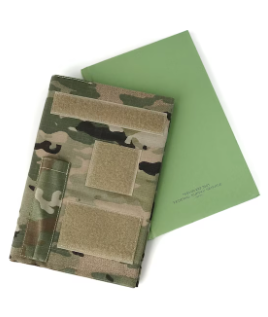  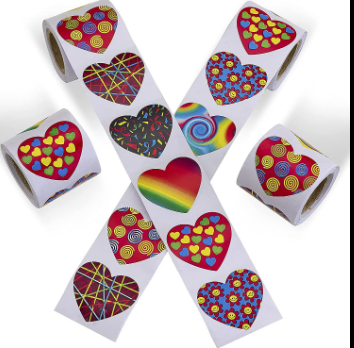 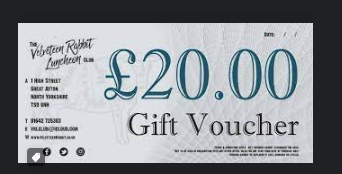

7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

In [ ]:
ItemUser = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['Description'], aggfunc=np.sum)
ItemUser.fillna(value=0, inplace=True)
ItemUser.head(2)
# Buscar el cliente de posición: 12346.0

In [ ]:
Item_Item = pd.DataFrame(cosine_similarity(ItemUser))
Item_Item.head(2)

In [ ]:
ItemUser[ItemUser.index == 12347.0]

8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

In [ ]:
# Lista stopwords en inglés
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "something", "doesn", "even", "article", "behind", "much", "towards", "next", "since", "upon", "a", "s", "the", "to", "and", "in", "of", "is", "you", "for", "on", "it", "my", "that", "with", "be", "this", "at", "me", "was", "like", "so", "but", "just", "have", "are", "he", "from", "all", "not", "if", "can", "we", "your", "as", "one", "by", "out", "up", "will", "when", "about", "new", "what", "an", "get", "they", "his", "now", "has", "do", "love", "or", "don", "no", "who", "good", "her", "more", "know", "see", "how", "there", "day", "she", "time", "go", "think", "would", "lol", "people", "got", "re", "today", "only", "some", "movie", "back", "great", "going", "over", "world", "had", "our", "want", "watching", "best", "why", "really", "him", "life", "still", "make", "ll", "last", "first", "been", "right", "its", "should", "us", "too", "games", "after", "into", "big", "top", "before", "news", "video", "case", "court", "team", "does", "bang", "watch", "off", "white", "times", "turns", "man", "press", "heart", "free", "three", "black", "clubs", "home", "city", "teen", "shortly", "flight", "left", "match", "girls", "did", "done", "cannot", "again", "become", "never", "found", "better", "than", "other", "which", "even", "also", "same", "these", "though", "both", "their", "most", "much", "very", "any", "take", "almost", "may", "ever", "while", "made", "own", "where", "here", "view", "using", "during", "along", "through", "seen", "used", "year", "says", "long", "years", "old", "could", "pm", "ago", "week", "full", "next", "find", "live", "minute", "high", "need", "things", "site", "down", "look", "were", "say", "said", "search", "minutes", "inside", "rights", "reserved", "com", "post", "against", "two", "ahead", "least", "latest", "under", "then", "sees", "way", "being", "beyond", "part", "near", "daily", "photo", "making", "am", "read", "th", "around", "keep", "behind", "makes", "takes", "since", "them", "those", "wants", "move", "gets", "another", "saying", "doesn", "without", "every", "getting", "once", "might", "away", "put", "come", "didn", "many", "himself", "hasn", "such", "well", "because", "something", "use", "until", "wrong", "each", "below", "sure", "try", "must", "went", "between", "set", "however", "including", "became", "known", "text", "fig", "worth", "exactly", "enough", "quite", "aren", "across", "according", "within", "few", "lot", "among", "little", "doing", "yet", "per", "various", "whether", "further", "onto", "currently", "fast", "above", "otherwise", "although", "unlike", "together", "latestly", "aforementioned", "online", "information", "email", "copyright", "hours", "please", "english", "language", "click", "help", "privacy", "contact", "terms", "page", "policy", "account", "share", "service", "address", "work", "media", "follow", "blog", "money", "show", "reply", "add", "sign", "link", "posted", "content", "stay", "use", "users", "app", "website", "support", "via", "real", "web", "ad", "send", "download", "data", "the", "of", "and", "a", "in", "to", "it", "is", "was", "to", "i", "for", "you", "he", "be", "with", "on", "that", "by", "at", "are", "not", "this", "but", "s", "they", "his", "from", "had", "she", "which", "or", "we", "an", "were", "that", "been", "have", "their", "has", "would", "what", "will", "there", "if", "can", "all", "her", "as", "who", "have", "do", "that", "one", "said", "them", "some", "could", "him", "into", "its", "then", "two", "when", "up", "time", "my", "out", "so", "did", "about", "your", "now", "me", "no", "more", "other", "just", "these", "also", "people", "any", "first", "only", "new", "may", "very", "should", "as", "like", "her", "than", "as", "how", "well", "way", "our", "as", "between", "years", "er", "many", "those", "there", "ve", "being", "because", "based", "million", "different", "number", "provide", "access", "country", "end", "available", "report", "open", "days", "already", "working", "called", "receive", "process", "create", "able", "power", "change", "experience", "important", "told", "second", "current", "major", "order", "example", "level", "key", "neither", "direct", "nor", "directly", "indirectly", "mentioned", "disclaimer", "caused", "purposed", "details", "non", "vs", "built", "offs", "feel", "third", "solution", "user", "existing", "capable", "less", "instead", "whereas"]

In [ ]:
# Extraemos las palabras  
contador = CountVectorizer() 
vectorizador = TfidfVectorizer(stop_words = stopwords)  
vectorizador

In [ ]:
# Crear una matriz dispersa
cantidades = contador.fit_transform(ItemUser.columns)
valores = vectorizador.fit_transform(ItemUser.columns)
# Generate matrix of word vectors
tfidf_matrix = vectorizador.fit_transform(ItemUser.columns)
tfidf_matrix.shape

In [ ]:
tokens = vectorizador.get_feature_names()
tokens

In [ ]:
# 3.- Le paso una recomendacion
recomendacionrecomendacion = "PACK OF 20 SPACEBOY NAPKINS"

In [ ]:
preguntaVector = vectorizador.transform([recomendacion])
preguntaVector

In [ ]:
# print(preguntaVector)
def vector2df(vector, tokens):
    dfPregunta = pd.DataFrame()
    # Obtener la frecuencia de cada token en la pregunta
    frecuencias = np.array(vector.sum(axis=0))[0]
    # Imprimir los tokens y sus frecuencias
    # La función zip(tokens, frecuencias) combina las listas tokens y frecuencias para formar una secuencia de tuplas
    for token, frecuencia in zip(tokens, frecuencias):
        if frecuencia > 0:
            # print(token, frecuencia)
            dfPregunta.loc[token, "frecuencia"] = frecuencia
    dfPregunta = dfPregunta.sort_values("frecuencia", ascending=False)
    return dfPregunta
vector2df(preguntaVector, tokens)

In [ ]:
coseno_similares = cosine_similarity(preguntaVector, tfidf_matrix)
# Obtener el índice de los 10 mayores números de una lista de los productos que más se parecen 
mejores_resultados = np.argsort(coseno_similares)[0]
mejores_resultados = np.flip(mejores_resultados)[:100] # inverse rearrange on numpy
mejores_resultados

In [ ]:
for i in mejores_resultados:
    print(i)
    print(coseno_similares[0][i])
    # Obtener el vector de características del documento de interés
    vector_documento = tfidf_matrix[i]
    print(vector2df(vector_documento, tokens)[:5])
print(recomendacion)
print("\n")

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.

In [ ]:
data.isnull().sum()

In [ ]:
# Eliminamos los valores missings
df_filtrado = data.dropna()
df_filtrado.isnull().sum()

In [ ]:
# Agrupar por customerID y combinar las descripciones de ventas en una lista
agrupados = df_filtrado.groupby("InvoiceNo")["Description"].agg(list)
# Convertir el resultado en una lista de listas
datos = agrupados.tolist()
datos

In [ ]:
# Utilizar el algoritmo Apriori para generar conjuntos de elementos frecuentes y reglas de asociación
conjuntos_frecuentes = list(apriori(datos, min_support=0.05, min_confidence=0, min_lift=0))
print("\nConjutos de Frecuencia:")
for conjunto in conjuntos_frecuentes:
    print(conjunto.items)
print("\nReglas de Asociación:")
for conjunto in conjuntos_frecuentes:
    for regla in conjunto.ordered_statistics:
        antecedente = list(regla.items_base)
        consecuente = list(regla.items_add)
        confianza = regla.confidence
        lift = regla.lift
        print(f"{antecedente} -> {consecuente}, confianza = {confianza:.2f}, lift = {lift:.2f}")

    ASSORTED COLOUR BIRD ORNAMENT             JUMBO BAG RED RETROSPOT                   PARTY BUNTING  

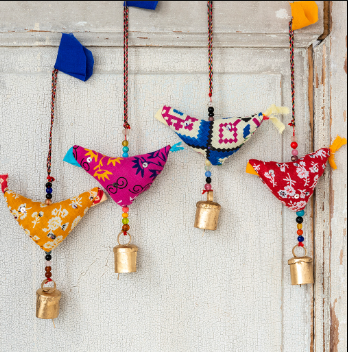      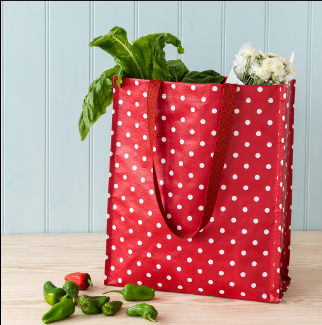    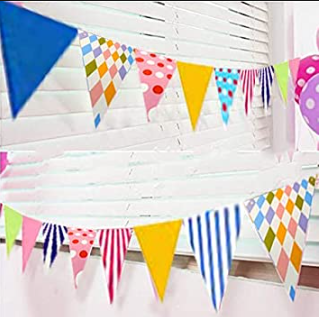